In [62]:
from constants import *
import pandas as pd
import matplotlib.pyplot as plt
from mcap_ros2.reader import read_ros2_messages

In [67]:
for msg in read_ros2_messages("../bagfiles/record9/record9_0.mcap"):
    if msg.channel.topic == "/model/vereniki/acceleration/angular":
        print(msg.ros_msg.z)

2.659279283527916e-06
1.361842621719983e-06
2.701918279612804e-06
3.1741110585701865e-06
1.5712367926542863e-06
1.8034260834319549e-07
-9.050046324144365e-07
-0.0009715813924054872
0.0016150788065952145
0.004384802671259327
0.007249919534121151
0.009944189700450475
0.012693085508066698
0.015377688578177073
0.01793457519829784
0.020440084264705685
0.023428366645213076
0.02467667344807406
0.025558111042611777
0.026245262448775914
0.027008273389617758
0.027808036896942927
0.028786767057134205
0.02972654549889175
0.03029468802818783
0.030387050094452136
0.029791869156183145
0.029099126818609742
0.028338852771887257
0.027416783280644834
0.026588694824398587
0.02582227496839511
0.025088753438307854
0.02428107291245986
0.02340845006481422
0.0224494265109244
0.0213417301764998
0.02112654155324837
0.019905253267752363
0.018843561703214627
0.017843939930765072
0.01694653570894774
0.016180937316348978
0.015437217661454613
0.014700208249473191
0.013982146794041186
0.013266621180093939
0.0125024697

In [108]:
def quaternion_to_yaw(quaternion):
    # Extract the relevant quaternion components
    q0, q1, q2, q3 = quaternion

    # Calculate yaw (rotation around the vertical axis)
    yaw = np.arctan2(2 * (q0 * q3 + q1 * q2), 1 - 2 * (q2**2 + q3**2))

    # Convert yaw from radians to degrees
    return np.degrees(yaw)

pos = np.empty((3, 0))
vel = np.empty((3, 0))
# acc = np.empty((0, 3))
angular_acc_z = []
linear_acc_xy = []

for msg in read_ros2_messages("../bagfiles/record9/record9_0.mcap"):
    if msg.channel.topic == "/model/vereniki/odometry":
        yaw = quaternion_to_yaw([msg.ros_msg.pose.pose.orientation.w,
                                 msg.ros_msg.pose.pose.orientation.x,
                                 msg.ros_msg.pose.pose.orientation.y,
                                 msg.ros_msg.pose.pose.orientation.z])
        
        pos = np.column_stack((pos, np.array([msg.ros_msg.pose.pose.position.x,
                                              msg.ros_msg.pose.pose.position.y,
                                              yaw])))
        vel = np.column_stack((vel, np.array([msg.ros_msg.twist.twist.linear.x,
                                              msg.ros_msg.twist.twist.linear.y,
                                              msg.ros_msg.twist.twist.angular.z])))


    if msg.channel.topic == "/model/vereniki/acceleration/linear":
        linear_acc_xy.append([msg.ros_msg.x, msg.ros_msg.y])

    if msg.channel.topic == "/model/vereniki/acceleration/angular":
        angular_acc_z.append(msg.ros_msg.z)

    
    
odom_data = {'Position-x': pos[0, :], 
        'Position-y': pos[1, :], 
        'Orientation-z': pos[2, :],
        'Velocity-x': vel[0, :],
        'Velocity-y': vel[1, :],
        'Velocity-z': vel[2, :]}

acc_data = pd.DataFrame(linear_acc_xy)
acc_data['Acceleration-z'] = angular_acc_z
acc_data.rename(columns={0: "Acceleration-x", 1: "Acceleration-y"}, inplace=True)

odom_sim_data = pd.DataFrame(odom_data)
acc_data = pd.DataFrame(acc_data)
odom_data_size = odom_sim_data.shape[0]
acc_data_size = acc_data.shape[0]

In [109]:
def align_values(data, size):
    selected_indices = np.linspace(0, len(data) - 1, size, dtype=int)
    return data.iloc[selected_indices].reset_index(drop=True)

In [110]:
diff_data = pd.read_csv('output.csv')
diff_data

,Position-x,Position-y,Orientation-z,Velocity-x,Velocity-y,Velocity-z,Acceleration-x,Acceleration-y,Acceleration-z
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000041,0.000000e+00,0.000000e+00,4.078554e-02
2,0.000000e+00,0.000000e+00,0.000002,0.000000e+00,-3.629752e-13,0.000048,0.000000e+00,-3.629752e-10,7.636468e-03
3,1.480414e-23,-3.629752e-16,0.000005,0.000000e+00,-7.132759e-13,0.000083,0.000000e+00,-3.503007e-10,3.457888e-02
4,7.843374e-23,-1.076251e-15,0.000010,1.161018e-21,-2.060832e-12,0.000096,1.161018e-18,-1.347557e-09,1.268102e-02
...,...,...,...,...,...,...,...,...,...
59995,7.179479e-02,-5.681649e-02,96.434501,-1.655669e-17,-1.796094e-02,0.143379,0.000000e+00,-3.482996e-07,1.393809e-08
59996,7.181264e-02,-5.681447e-02,96.442716,-1.655901e-17,-1.796094e-02,0.143379,-2.322035e-18,-3.482393e-07,1.393560e-08
59997,7.183049e-02,-5.681246e-02,96.450931,-1.655669e-17,-1.796094e-02,0.143379,2.322035e-18,-3.481790e-07,1.393311e-08
59998,7.184833e-02,-5.681044e-02,96.459146,-1.655669e-17,-1.796094e-02,0.143379,0.000000e+00,-3.481187e-07,1.393061e-08


In [111]:
x_pos_diff = align_values(diff_data['Position-x'], odom_data_size)
y_pos_diff = align_values(diff_data['Position-y'], odom_data_size)
z_orient_diff = align_values(diff_data['Orientation-z'], odom_data_size)

x_vel_diff = align_values(diff_data['Velocity-x'], odom_data_size)
y_vel_diff = align_values(diff_data['Velocity-y'], odom_data_size)
z_vel_diff = align_values(diff_data['Velocity-z'], odom_data_size)

x_acc_diff = align_values(diff_data['Acceleration-x'], acc_data_size)
y_acc_diff = align_values(diff_data['Acceleration-y'], acc_data_size)
z_acc_diff = align_values(diff_data['Acceleration-z'], acc_data_size)

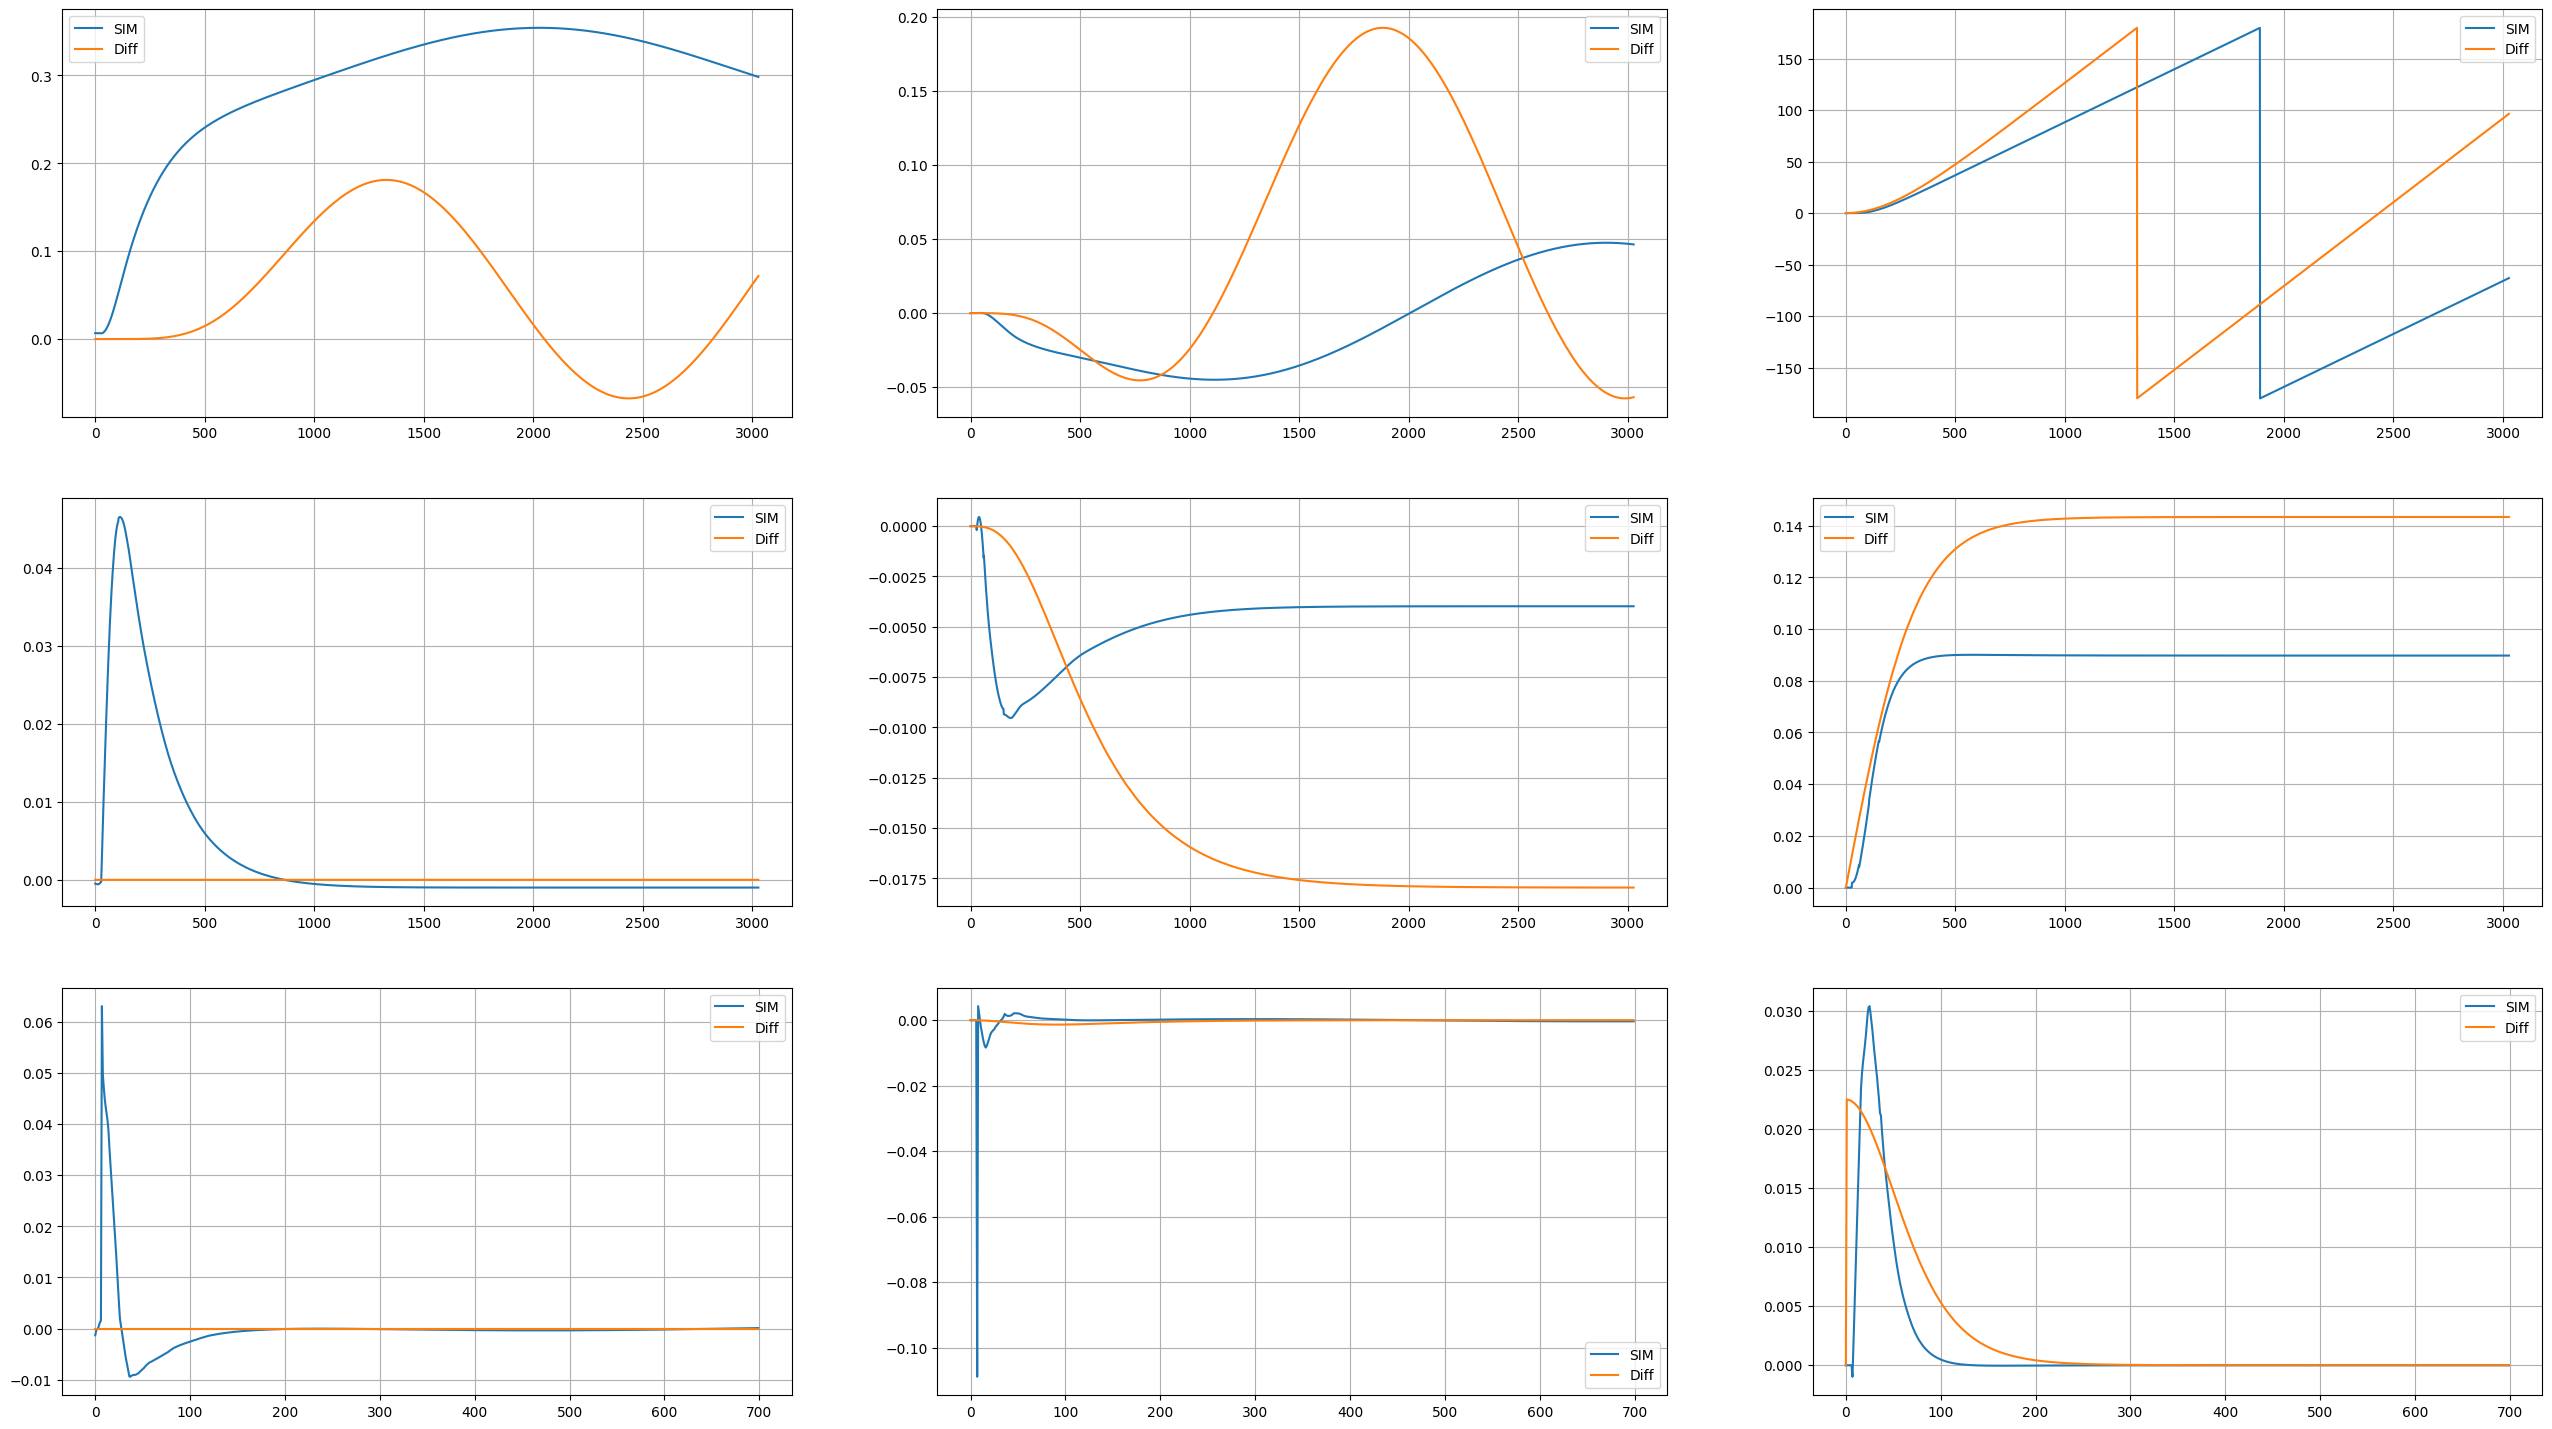

In [113]:
fig, ax = plt.subplots(3, 3, sharex=False, sharey=False)
fig.set_figwidth(32)
fig.set_figheight(18)

# Pose 

ax[0, 0].plot(odom_data['Position-x'], label='SIM')
ax[0, 0].plot(x_pos_diff, label='Diff')

ax[0, 1].plot(odom_data['Position-y'], label='SIM')
ax[0, 1].plot(y_pos_diff, label='Diff')

ax[0, 2].plot(pd.DataFrame(odom_data['Orientation-z']), label='SIM')
ax[0, 2].plot(z_orient_diff, label='Diff')

# Twist
ax[1, 0].plot(odom_data['Velocity-x'], label='SIM')
ax[1, 0].plot(x_vel_diff, label='Diff')

ax[1, 1].plot(odom_data['Velocity-y'], label='SIM')
ax[1, 1].plot(y_vel_diff, label='Diff')

ax[1, 2].plot(pd.DataFrame(odom_data['Velocity-z']), label='SIM')
ax[1, 2].plot(z_vel_diff, label='Diff')

# Acceleration
ax[2, 0].plot(acc_data['Acceleration-x'], label='SIM')
ax[2, 0].plot(x_acc_diff, label='Diff')

ax[2, 1].plot(acc_data['Acceleration-y'], label='SIM')
ax[2, 1].plot(y_acc_diff, label='Diff')

ax[2, 2].plot(pd.DataFrame(acc_data['Acceleration-z']), label='SIM')
ax[2, 2].plot(z_acc_diff, label='Diff')

for i in range(3):
    for j in range(3):
        ax[i, j].grid(True)
        ax[i, j].legend()

plt.show()

In [114]:
x_pos_diff = align_values(diff_data['Position-x'], odom_data_size)
y_pos_diff = align_values(diff_data['Position-y'], odom_data_size)
z_orient_diff = align_values(diff_data['Orientation-z'], odom_data_size)


In [115]:
df1 = pd.DataFrame({'Position-x': x_pos_diff, 'Position-y': y_pos_diff, 'Orientation-z': z_orient_diff})
df2 = pd.DataFrame(odom_data)

In [116]:
def plot3_1(values1, values2, title):
    fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)

    ax[0].plot(values1.iloc[:, 0])
    ax[1].plot(values1.iloc[:, 1])
    ax[2].plot(values1.iloc[:, 2])
    ax[0].plot(values2.iloc[:, 0])
    ax[1].plot(values2.iloc[:, 1])
    ax[2].plot(values2.iloc[:, 2])

    fig.set_figwidth(16)
    fig.set_figheight(9)
    fig.suptitle(title, fontsize=20)
    for i in range(3):
        ax[i].grid(True)

    return ax, fig

(array([<Axes: >, <Axes: >, <Axes: >], dtype=object),
 <Figure size 1600x900 with 3 Axes>)

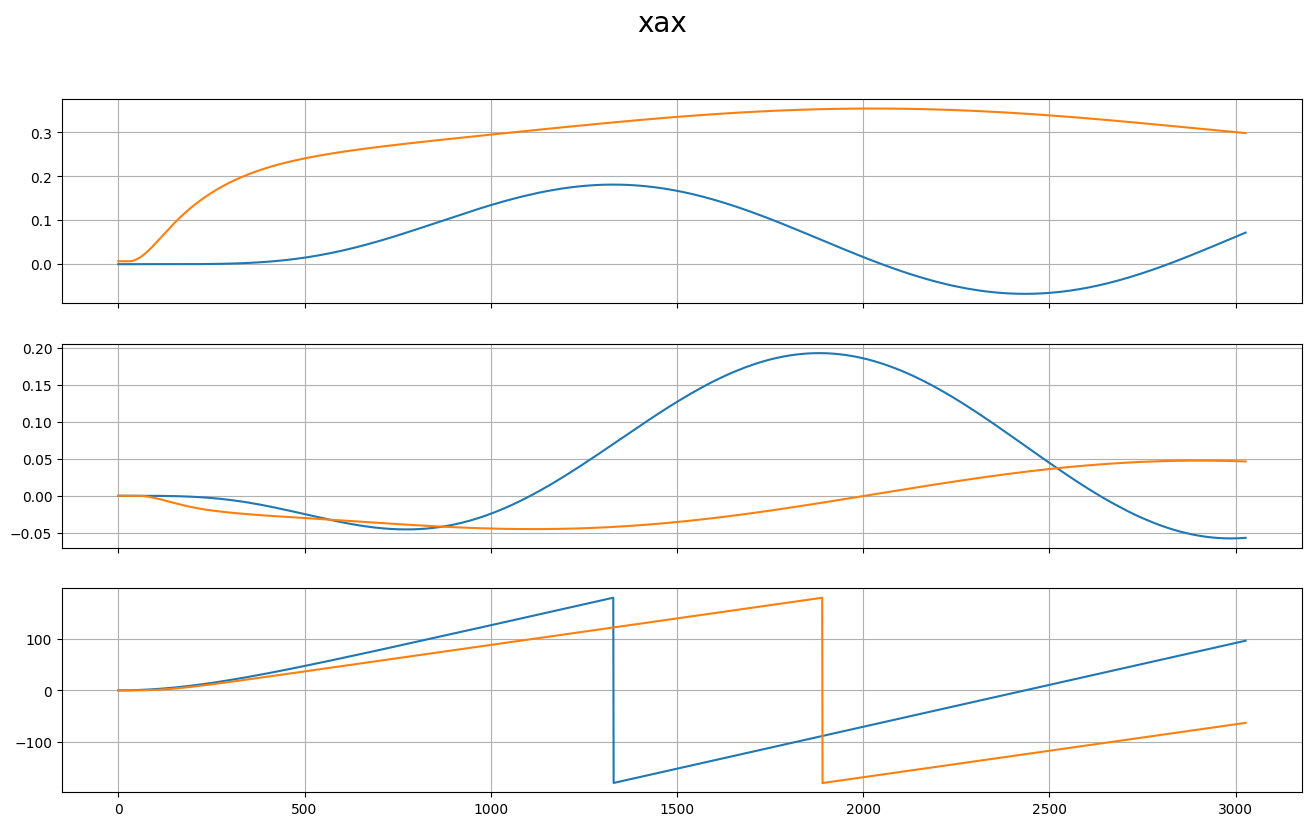

In [117]:
plot3_1(df1, df2, "xax")